# Setup

### Imports

Import the necessary libraries to handle navigating the filesystem and accessing the images in the data folder. Numpy for numerical operations and pyplot to plot results

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Import the relevant skimage libraries for feature extraction (HoG and LBP) and classification (SVM)

In [4]:
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

To produce metrics about the result, such as a confusion matrix, import the following:

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

### Mounting

Mount and access Google drive, which hosts the files for the JAFFE and CK+ dataset images (for both training and testing)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/AI/Assignment/
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/AI/Assignment


'/content/drive/MyDrive/Colab Notebooks/AI/Assignment'

# Model

### Face Detection

Firstly, load `haarcascade_frontalface_default.xml` for face detection. This is a pre-trained face detection model used by OpenCV, trained using Haar-like features (patterns of contrast).

In [7]:
face_cascade = cv2.CascadeClassifier("./FER_Model/haarcascade_frontalface_default.xml")

Now create a function which will load, label and crop all facial images from a folder.

It assumes that the folder is divided into subfolders of each emotion type (happiness, sadness, etc.) -- these are the "labels" for each image.

From this function, an "images" array and a "labels" array are populated with the cropped images as well as the labels for each face. If the indexes are consistent then each label should map properly to each face image.

In [8]:
# Function to load images, detect faces, and prepare them for feature extraction
def load_and_crop_faces(folder_path):
    images = []
    labels = []

    # Loop through all of the subfolders in the path given
    for label in os.listdir(folder_path):
        # label = happiness, sadness, etc.
        label_path = os.path.join(folder_path, label)

        # Skip non-folders
        if not os.path.isdir(label_path):
            continue

        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)

            # Read the image (it is greyscale so only use one channel)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Ignore any empty or broken image files
            if img is None:
                continue

            # Detect face
            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # For each face in the image
            for (x, y, w, h) in faces:
                # Crop to the Region of Interest
                face_region = img[y:y+h, x:x+w]

                # Add this face to the list of loaded images
                images.append(face_region)

                # Add the label (should be the same index) to the list of labels
                labels.append(label)

    return images, labels


Now we will run the function on both datasets as we need the images from both. Important to note that:


*   X_train, X_test ⟶ The cropped images
*   y_train, y_test ⟶ The labels



In [9]:
# Perform on CK+ Dataset
CK_train_folder_path = "./CK/Converted/Training"
CK_test_folder_path = "./CK/Converted/Test"

CK_X_train, CK_y_train = load_and_crop_faces(CK_train_folder_path)
CK_X_test, CK_y_test = load_and_crop_faces(CK_test_folder_path)


# Perform on JAFFE Dataset
JAFFE_train_folder_path = "./JAFFE/Converted/Training"
JAFFE_test_folder_path = "./JAFFE/Converted/Test"

JAFFE_X_train, JAFFE_y_train = load_and_crop_faces(JAFFE_train_folder_path)
JAFFE_X_test, JAFFE_y_test = load_and_crop_faces(JAFFE_test_folder_path)

### Feature Extraction

Both HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) will be used to extract features as the benefits of both will be gained.


*   HOG captures gradient shapes. This is great for eyebrows, mouth curvature, eye tightening.
*   LBP captures local "textures". This is great for wrinkles, furrows, subtle micro-textures.

Therefore a function will be created that extracts features using both of those techniques, and then combines the feature vectors together into one and returns it.

In [10]:
# LBP parameters
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"

def extract_hog_lbp_features(image, visualise_hog=False):
    normalised_image = cv2.resize(image, (128, 128))

    # Perform HOG feature extraction
    hog_features = hog(
        normalised_image,         # Image to use
        orientations=9,           # Number of gradient orientation bins
        pixels_per_cell=(8, 8),   # HOG calculates histogram per cell, so what is the cell size
        cells_per_block=(2, 2),   # Cells per block, blocks are used to reduce lighting variation
        block_norm='L2-Hys',      # Method to normalise each block. L2-Hys is standard
        visualize=False,          # Return a HOG image or not
        feature_vector=True       # Flatten the output into a 1d feature vector to combine with LBP
    )

    # Perform LBP feature extraction
    lbp = local_binary_pattern(normalised_image, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)

    # Build histogram for LBP
    (lbp_hist, _) = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )

    # Normalise the LBP histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # Combine the feature vector for LBP and HOG
    features = np.hstack([hog_features, lbp_hist])

    return features

The function will define a feature vector considering the characteristics of both HOG and LBP in that order. However this must be done for the entire dataset, not just one image/label.

Therefore, another function will be defined, to parse the entire sets of images and labels of each dataset that was collected from the Face Detection (`load_and_crop_faces`) method.

In [11]:
def build_feature_set(images, labels):
    X_features = []
    y_labels = []

    for img, lbl in zip(images, labels):
        # Extract the feature vector for this image
        features = extract_hog_lbp_features(img)

        # Append the feature vector into X_features and the label into y_labels

        # Assuming the indexes are consistent, then the labels should identify
        # the feature vectors according to the correct class.
        X_features.append(features)
        y_labels.append(lbl)

    return np.array(X_features), np.array(y_labels)

This function must be applied to both datasets so that we can build feature vectors of each image in the dataset alongside corresponding labels.

In [12]:
# Perform on CK+ dataset
CK_X_train_feat, CK_y_train_feat = build_feature_set(CK_X_train, CK_y_train)
CK_X_test_feat, CK_y_test_feat = build_feature_set(CK_X_test, CK_y_test)

# Perform on JAFFE dataset
JAFFE_X_train_feat, JAFFE_y_train_feat = build_feature_set(JAFFE_X_train, JAFFE_y_train)
JAFFE_X_test_feat, JAFFE_y_test_feat = build_feature_set(JAFFE_X_test, JAFFE_y_test)

### Classification

The string labels for each of the emotions must firstly be encoded to integers for the SVM model to use. For example:


*   "Anger" ⟶ 0
*   "Happiness" ⟶ 1
*   etc.



In [13]:
label_encoder = LabelEncoder()

# Concatenate the labels from the train and test features of each dataset.
# Ideally, the labels should be the same accross all of these, however it is good
# to perform as a precautionary measure
all_labels = np.concatenate([CK_y_train_feat, CK_y_test_feat, JAFFE_y_train_feat, JAFFE_y_test_feat])

label_encoder.fit(all_labels)

# Encode CK+ labels
CK_y_train_encoded = label_encoder.transform(CK_y_train_feat)
CK_y_test_encoded = label_encoder.transform(CK_y_test_feat)

# Encode JAFFE labels
JAFFE_y_train_encoded = label_encoder.transform(JAFFE_y_train_feat)
JAFFE_y_test_encoded = label_encoder.transform(JAFFE_y_test_feat)

Because we used both HOG and LBP feature extraction methods, there is the potential for bias in one of these.

For example, if HOG features presented values from 0-255 whilst LBP presented probabilities between 0-1, the HOG features would heavily outweigh the LBP in the model, which we do not want.

Therefore, feature scaling must be applied to the model so that all features contribute equally to the SVM classifier.

In [14]:
scaler = StandardScaler()

# Scale CK+ training features
CK_X_train_scaled = scaler.fit_transform(CK_X_train_feat)
CK_X_test_scaled = scaler.transform(CK_X_test_feat)

# Scale JAFFE training features
JAFFE_X_train_scaled = scaler.fit_transform(JAFFE_X_train_feat)
JAFFE_X_test_scaled = scaler.transform(JAFFE_X_test_feat)

Now the SVM Classifier can be trained on the encoded and scaled features. The Kernel can be linear or RBF.

It will be fit and tested on CK+ data, and then JAFFE. The results will be recorded for each.

In [15]:
# Create the classifier

# random_state controls some randomness in the internal process, such as shuffling, however SVM should be mostly deterministic
SVM_Classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)

Starting with CK+:

In [16]:
# Train on CK+ dataset
SVM_Classifier.fit(CK_X_train_scaled, CK_y_train_encoded)

# Predict on CK+ test set
CK_y_pred = SVM_Classifier.predict(CK_X_test_scaled)

Then JAFFE:

In [17]:
# Train on CK+ dataset
SVM_Classifier.fit(JAFFE_X_train_scaled, JAFFE_y_train_encoded)

# Predict on CK+ test set
JAFFE_y_pred = SVM_Classifier.predict(JAFFE_X_test_scaled)

# Results


### Confusion Matrix

A confusion matrix is a table that summarises the performance of the classification model by comparing the model’s predicted labels/emotions with the true labels.

Each row represents the actual emotion, and each column represents the predicted emotion made by the classifier. The quantity in each cell is the number of guesses made by the model.

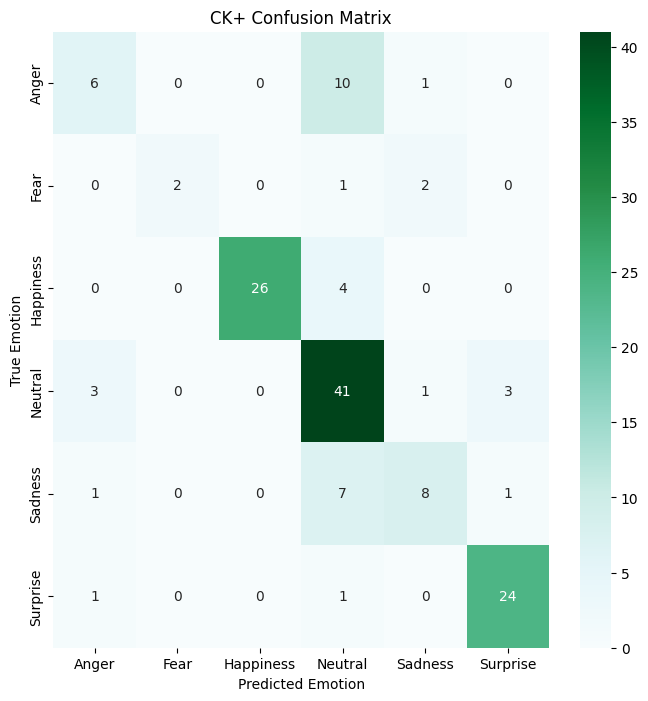

In [18]:
# CK+ Confusion Matrix
CK_conf_matrix = confusion_matrix(CK_y_test_encoded, CK_y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(CK_conf_matrix, annot=True, fmt="d", cmap="BuGn", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("CK+ Confusion Matrix")
plt.ylabel("True Emotion")
plt.xlabel("Predicted Emotion")
plt.show()


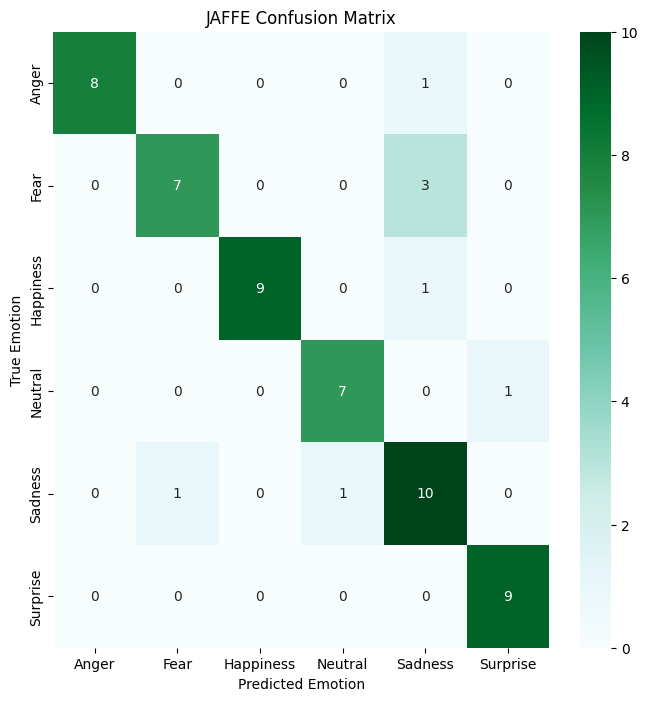

In [19]:
# JAFFE Confusion Matrix
JAFFE_conf_matrix = confusion_matrix(JAFFE_y_test_encoded, JAFFE_y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(JAFFE_conf_matrix, annot=True, fmt="d", cmap="BuGn", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("JAFFE Confusion Matrix")
plt.ylabel("True Emotion")
plt.xlabel("Predicted Emotion")
plt.show()


### Normalised Confusion Matrix

A normalised confusion matrix presents the percentage of guesses for each cell, rather than the raw number of guesses. This way, the colour grading of the heatmap represents the proportion and distribution of guesses as opposed to just the quantity.

This prevents emotions with less samples in the dataset from losing their colour in the matrix automatically. As a result, it makes accurate and inaccurate guesses more visible and clear.

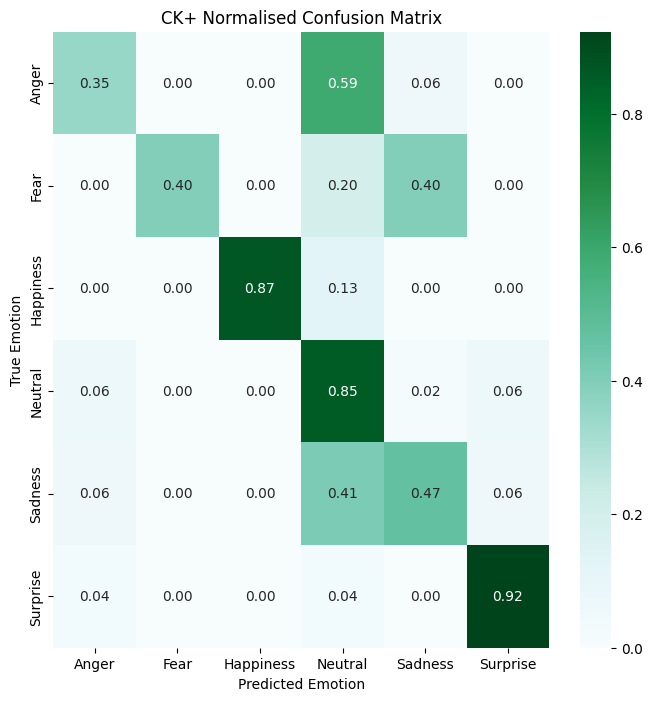

In [20]:
# Normalised CK+ Confusion Matrix
CK_conf_matrix_norm = confusion_matrix(
    CK_y_test_encoded, CK_y_pred, normalize='true'
)

plt.figure(figsize=(8, 8))
sns.heatmap(CK_conf_matrix_norm, annot=True, fmt=".2f", cmap="BuGn",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("CK+ Normalised Confusion Matrix")
plt.ylabel("True Emotion")
plt.xlabel("Predicted Emotion")
plt.show()

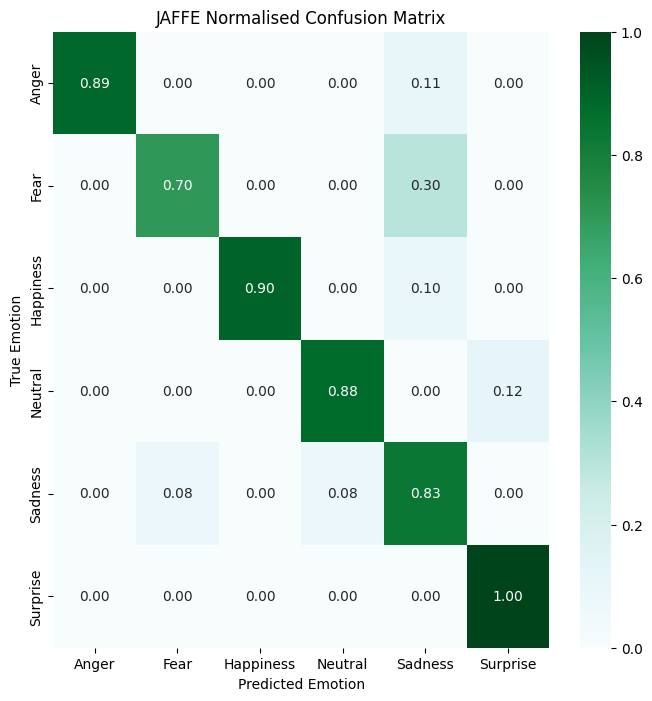

In [21]:
# Normalised CK+ Confusion Matrix
JAFFE_conf_matrix_norm = confusion_matrix(
    JAFFE_y_test_encoded, JAFFE_y_pred, normalize='true'
)

plt.figure(figsize=(8, 8))
sns.heatmap(JAFFE_conf_matrix_norm, annot=True, fmt=".2f", cmap="BuGn",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("JAFFE Normalised Confusion Matrix")
plt.ylabel("True Emotion")
plt.xlabel("Predicted Emotion")
plt.show()

### Training/Testing Accuracy

The training/testing accuracy represents a higher accuracy in JAFFE than CK+, by approx. 11.38 percentage points. Likely due to differences in subject demographics and subtlety in any expressed emotions.

In [22]:
CK_accuracy = accuracy_score(CK_y_test_encoded, CK_y_pred)
print(f"CK+ Test Accuracy: {CK_accuracy:.4f}")

JAFFE_accuracy = accuracy_score(JAFFE_y_test_encoded, JAFFE_y_pred)
print(f"JAFFE Test Accuracy: {JAFFE_accuracy:.4f}")

CK+ Test Accuracy: 0.7483
JAFFE Test Accuracy: 0.8621


### Classification Report

The classification report provides some unique insight over the other results.

*   Precision rating = the proportion of correct predictions out of *all predictions* made for that class
*   Recall rating = the proportion of correct guesses out of the total number of *samples* for that class

The f1-score in particular gives unique insight because it combines precision and recall with a harmonic mean.

In [23]:
print("CK+ Classification Report:")
print(classification_report(CK_y_test_encoded, CK_y_pred, target_names=label_encoder.classes_))

print("JAFFE Classification Report:")
print(classification_report(JAFFE_y_test_encoded, JAFFE_y_pred, target_names=label_encoder.classes_))

CK+ Classification Report:
              precision    recall  f1-score   support

       Anger       0.55      0.35      0.43        17
        Fear       1.00      0.40      0.57         5
   Happiness       1.00      0.87      0.93        30
     Neutral       0.64      0.85      0.73        48
     Sadness       0.67      0.47      0.55        17
    Surprise       0.86      0.92      0.89        26

    accuracy                           0.75       143
   macro avg       0.78      0.64      0.68       143
weighted avg       0.76      0.75      0.74       143

JAFFE Classification Report:
              precision    recall  f1-score   support

       Anger       1.00      0.89      0.94         9
        Fear       0.88      0.70      0.78        10
   Happiness       1.00      0.90      0.95        10
     Neutral       0.88      0.88      0.88         8
     Sadness       0.67      0.83      0.74        12
    Surprise       0.90      1.00      0.95         9

    accuracy         